# Add imports

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array

from matplotlib import pyplot as plt

import numpy as np


2025-08-28 15:18:36.376397: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 15:18:36.437482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2025-08-28 15:18:37.328118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# 1. Load dataset

In [2]:
data_dir = "dataset"

img_size = (224, 224)
batch_size = 32

## 1.1. Split dataset into training and validation

In [3]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 3052 files belonging to 7 classes.
Using 2442 files for training.


I0000 00:00:1756408718.467312   84803 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29041 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5090, pci bus id: 0000:01:00.0, compute capability: 12.0


In [4]:
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 3052 files belonging to 7 classes.
Using 610 files for validation.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

## 1.2. Prefetching to improve performance

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 2. Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 3. Load Pre-trained MobileNetV2

In [8]:
base_model = MobileNetV2(input_shape=img_size + (3,),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False

# 4. Build Model

In [9]:
inputs = tf.keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # preprocess for MobileNetV2

x = base_model(x, training=False)  # no BN updates
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # helps prevent overfitting
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs, outputs)

# 5. Compile

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 6. Train

In [11]:
# add early stopping for when val_loss does not improve for a set number of epoch
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [12]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    callbacks=[early_stopping])

Epoch 1/30


I0000 00:00:1756408730.394487   84893 cuda_dnn.cc:529] Loaded cuDNN version 91200


77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.2555 - loss: 1.9818 - val_accuracy: 0.3787 - val_loss: 1.6007
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4333 - loss: 1.4981 - val_accuracy: 0.5918 - val_loss: 1.2127
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5528 - loss: 1.2281 - val_accuracy: 0.6852 - val_loss: 0.9762
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6360 - loss: 1.0166 - val_accuracy: 0.7246 - val_loss: 0.8335
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6843 - loss: 0.9052 - val_accuracy: 0.7738 - val_loss: 0.7288
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7211 - loss: 0.7993 - val_accuracy: 0.7934 - val_loss: 0.6545
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7400 - loss: 0.7512 - val_accuracy: 0.7984 - val_loss: 0.6032
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7629 - loss: 0.6959 - val_accuracy: 0.8082 - val_loss: 0.

# 7. Fine-tune

In [13]:
base_model.trainable = True
for layer in base_model.layers[:]:  # freeze all but last 40 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=30,
                         callbacks=[early_stopping])

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8817 - loss: 0.3561 - val_accuracy: 0.8984 - val_loss: 0.3219
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8628 - loss: 0.3812 - val_accuracy: 0.8984 - val_loss: 0.3218
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8681 - loss: 0.3827 - val_accuracy: 0.9000 - val_loss: 0.3212
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8763 - loss: 0.3613 - val_accuracy: 0.9033 - val_loss: 0.3205
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8743 - loss: 0.3722 - val_accuracy: 0.9033 - val_loss: 0.3196
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8718 - loss: 0.3675 - val_accuracy: 0.9033 - val_loss: 0.3195
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8702 - loss: 0.3616 - val_accuracy: 0.9033 - val_loss: 0.3198
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8657 - loss: 0.3849 - val_accuracy: 0.9033 - v

# Show graph

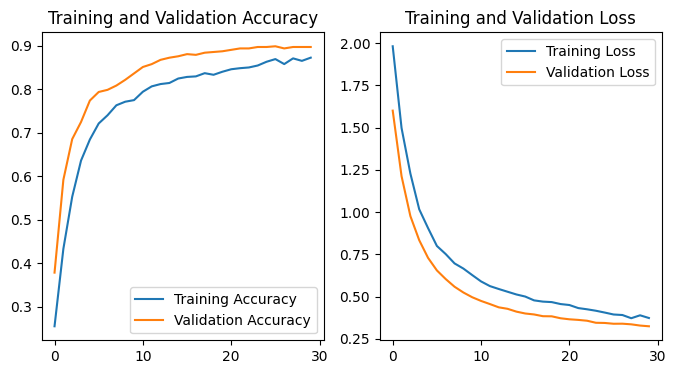

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Test image

In [15]:

def predict_single_image(img_path, model, class_names, top_k=3):
    # load and prepare image (do NOT call preprocess_input here because the model already does it)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)            # shape (224,224,3)
    img_array = np.expand_dims(img_array, axis=0)  # shape (1,224,224,3)

    preds = model.predict(img_array)               # model will preprocess internally
    probs = preds[0]
    top_idx = np.argsort(probs)[-top_k:][::-1]
    return [(class_names[i], float(probs[i])) for i in top_idx]


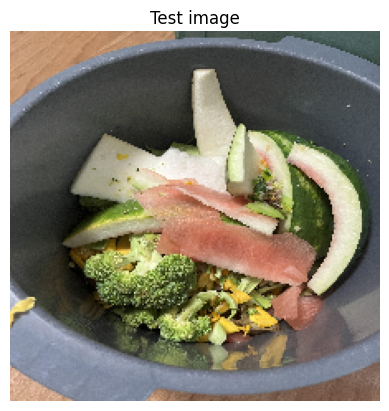

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Top predictions: [('food_waste', 0.9303616881370544), ('cardboard', 0.02833935245871544), ('furniture', 0.013584977947175503)]


In [22]:
img_path = "test/food_waste4.jpg"
img_vis = image.load_img(img_path, target_size=(224,224))
plt.imshow(img_vis); plt.axis('off'); plt.title("Test image"); plt.show()

print("Top predictions:", predict_single_image(img_path, model, class_names, top_k=3))